In [1]:
from PIL import Image
import numpy as np
import os
import cv2

In [8]:
data=[]
labels=[]
size=224
Sol=os.listdir("./Data/Sol/")
for taj in Sol:
    imag=cv2.imread("./Data/Sol/"+taj)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(0)

Taj_Mahal=os.listdir("./Data/Taj_Mahal")
for taj in Taj_Mahal:
    imag=cv2.imread("./Data/Taj_Mahal/"+taj)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(1)
    
Tour_Effel=os.listdir("./Data/Tour_Effel")
for tour in Tour_Effel:
    imag=cv2.imread("./Data/Tour_Effel/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(2)
    
Big_Ben=os.listdir("./Data/Big_Ben/")
for tour in Big_Ben:
    imag=cv2.imread("./Data/Big_Ben/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(3)
Towers=os.listdir("./Data/Towers")
for tour in Towers:
    imag=cv2.imread("./Data/Towers/"+tour)
    img_from_ar = Image.fromarray(imag, 'RGB')
    resized_image = img_from_ar.resize((size, size))
    data.append(np.array(resized_image))
    labels.append(4)

In [9]:
monuments=np.array(data)
labels=np.array(labels)

In [10]:
s=np.arange(monuments.shape[0])
np.random.shuffle(s)
monuments=monuments[s]
labels=labels[s]

In [11]:
num_classes=len(np.unique(labels))
data_length=len(monuments)
print(len(monuments))
num_classes

2402


5

In [6]:
x_train=monuments[:(int)(0.7*data_length)]
x_val=monuments[(int)(0.7*data_length):]
train_length=len(x_train)
val_length=len(x_val)
print(len(x_train))
print(len(x_val))

1681
721


In [7]:
y_train=labels[:(int)(0.7*data_length)]
y_val=labels[(int)(0.7*data_length):]
print(len(y_train))
print(len(y_val))

1681
721


In [8]:
import keras
from keras.utils import np_utils
#One hot encoding
y_train=keras.utils.to_categorical(y_train,num_classes)
y_val=keras.utils.to_categorical(y_val,num_classes)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [9]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=.05, 
                                   width_shift_range=.05,
                                   height_shift_range=.05, 
                                   horizontal_flip = 'true')
train_generator = train_datagen.flow(x_train, y_train,
                                     batch_size=BATCH_SIZE, seed=1)
                                     
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val, 
                                   batch_size=BATCH_SIZE, seed=1)

In [10]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.applications import VGG19
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Get the InceptionV3 model so we can do transfer learning


base_inception = VGG19(weights='imagenet', include_top=False, 
                             input_shape=(224, 224, 3))
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.7)(out)
out = Dense(512, activation='relu')(out)
out = Dropout(0.7)(out)
predictions = Dense(num_classes, activation='softmax')(out)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
#model.summary()
learning_rate=1e-4
model.compile(optimizer = Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 
batch_size = 32
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=30)
mc = ModelCheckpoint('VGG19_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# fit model
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=1000, verbose=1,callbacks=[es, mc])

80142336/80134624 [==============================] - 16s 0us/step
Epoch 1/1000
52/52 [==============================] - 25s 473ms/step - loss: 1.9943 - acc: 0.2169 - val_loss: 1.5955 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to VGG19_best_model.h5
Epoch 2/1000
52/52 [==============================] - 20s 385ms/step - loss: 1.7940 - acc: 0.2373 - val_loss: 1.5185 - val_acc: 0.2569

Epoch 00002: val_acc improved from 0.25000 to 0.25689, saving model to VGG19_best_model.h5
Epoch 3/1000
52/52 [==============================] - 20s 378ms/step - loss: 1.6608 - acc: 0.2823 - val_loss: 1.4819 - val_acc: 0.2874

Epoch 00003: val_acc improved from 0.25689 to 0.28737, saving model to VGG19_best_model.h5
Epoch 4/1000
52/52 [==============================] - 20s 377ms/step - loss: 1.5663 - acc: 0.3017 - val_loss: 1.4262 - val_acc: 0.3687

Epoch 00004: val_acc improved from 0.28737 to 0.36865, saving model to VGG19_best_model.h5
Epoch 5/1000
52/52 [=========

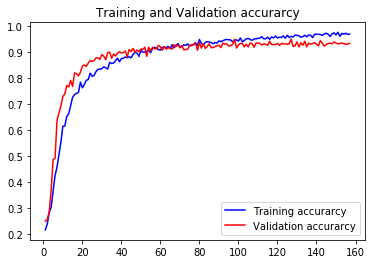

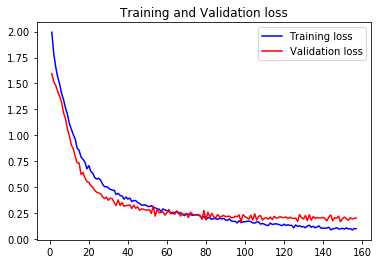

In [11]:
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()